In [3]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

import scipy.stats
import statsmodels.stats.multitest
from scipy.special import logit

from importlib import reload

from pathlib import Path
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

fdr_threshold = 0.05
correlations = {} 
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]


def comparer(dat, which = [("ase", "beta"),("asb","beta")], threshold = 0.05):
    
    is_sig = [ (dat[ "%s_q%s" % g ] < threshold) for g in which ]    
    for j,k in ((0,1),(1,0)):
        subset_sig = is_sig[j][ is_sig[k] ].mean()
        backg_sig = is_sig[j].mean()
        print("Prop significant for %s (%s)" % which[j], 
              "out of %s (%s) hits:" % which[k], 
              "%.3f" % subset_sig, 
             "(%.3f background rate, x%.2f enrichment)" % (backg_sig, subset_sig/backg_sig))
    effs = [ dat[ "%s_loc%s" % g] for g in which ]
    x_col,y_col = [ "%s_loc%s" % g for g in which ]
    
    raw_correlation = scipy.stats.pearsonr(dat[x_col],dat[y_col])
    print("Correlation of effect sizes %.3f (p=%.3g)" 
          % raw_correlation) 
    sig_in_either = dat[is_sig[0] | is_sig[1]]
    print("Correlation of sig effect sizes %.3f (p=%.3g)" 
          % scipy.stats.pearsonr(sig_in_either[x_col],sig_in_either[y_col])) 
    print("Prop sig effect sizes with matching sign %.3f" 
          % ((sig_in_either[x_col]>0)==(sig_in_either[y_col]>0)).mean())
    
    plt.figure(figsize=(5,4))
    # sns.scatterplot(data = dat, x="%s_loc%s" % which[0], y="%s_loc%s" % which[1], hue = "hue", alpha = 0.1, linewidth=0)
    sns.scatterplot(data = dat[~is_sig[0] & ~is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "Null",
                    color="gray", alpha = 1, linewidth=0)
    sns.scatterplot(data = dat[is_sig[0] & ~is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "Significant for %s%s only" % which[0], 
                    color="red", alpha = 0.2, linewidth=0)
    sns.scatterplot(data = dat[~is_sig[0] & is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "Significant for %s%s only" % which[1], 
                    color="green", alpha = 0.2, linewidth=0)
    sns.scatterplot(data = dat[is_sig[0] & is_sig[1]], 
                    x=x_col, 
                    y=y_col, 
                    label = "Significant in both",
                    color="blue", alpha = 0.3, linewidth=0)
    #sns.kdeplot(dat.loc[:,x_col], dat.loc[:,y_col], bw_method = 0.1, levels = 4)
    leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    for lh in leg.legendHandles: lh.set_alpha(1)
    #plt.show()
    
    return raw_correlation[0]


/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gaussian model replicates for hnRNPK

Compare ASE between replicates. This looks good... but isn't what we actually care about estimating! 

Prop significant for ase (_1) out of ase (_2) hits: 0.404 (0.118 background rate, x3.41 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.382 (0.112 background rate, x3.41 enrichment)
Correlation of effect sizes 0.537 (p=0)
Correlation of sig effect sizes 0.709 (p=0)
Prop sig effect sizes with matching sign 0.821


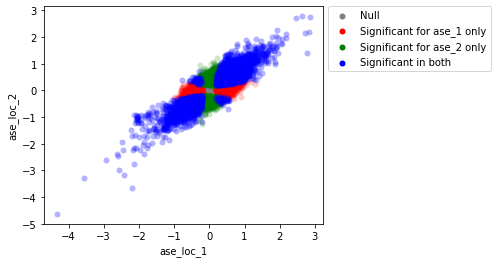

In [30]:
reps = [1,2]
correlations["gaussian"] = {}
res = [ pd.read_csv(results_dir / ("normal_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in reps ]
res_sub = [ g.loc[:,cols_to_keep] for g in res ]
merged = res_sub[0].merge(res_sub[1], on = ["variantID", "refAllele", "altAllele"], suffixes = ["_1","_2"])
correlations["gaussian"]["ase_reps"] = comparer(merged, [("ase","_1"),("ase","_2")])  # 0.16, sigcor 0.30

Compare ASB between replicates. This also looks pretty good, but we're concerned ASE is bleeding into the ASB estimates. 

Prop significant for asb (_1) out of asb (_2) hits: 0.147 (0.015 background rate, x10.03 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.143 (0.014 background rate, x10.03 enrichment)
Correlation of effect sizes 0.196 (p=0)
Correlation of sig effect sizes 0.493 (p=0)
Prop sig effect sizes with matching sign 0.736


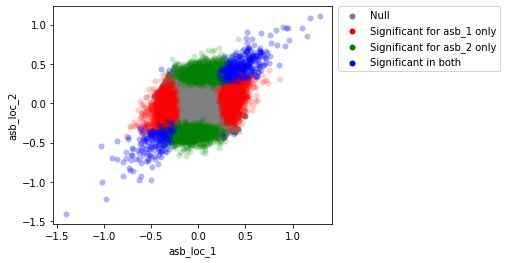

In [31]:
correlations["gaussian"]["asb_reps"] = comparer(merged, [("asb","_1"),("asb","_2")])  # 0.16, sigcor 0.30

In [32]:
merged.asb_loc_2.mean()

0.0014155010042111275

ASE vs ASB. The correlation here is very high which is concerning. Strong evidence that ASE is bleeding into ASB. We think this is because the gaussian prior prefers to share observed allelic imbalance between the ASE and ASB, even if it could be more parsimoniously explained as just ASE. 

Prop significant for ase (_1) out of asb (_1) hits: 0.473 (0.118 background rate, x3.99 enrichment)
Prop significant for asb (_1) out of ase (_1) hits: 0.058 (0.015 background rate, x3.99 enrichment)
Correlation of effect sizes 0.346 (p=0)
Correlation of sig effect sizes 0.580 (p=0)
Prop sig effect sizes with matching sign 0.734
Prop significant for ase (_2) out of asb (_2) hits: 0.413 (0.112 background rate, x3.69 enrichment)
Prop significant for asb (_2) out of ase (_2) hits: 0.052 (0.014 background rate, x3.69 enrichment)
Correlation of effect sizes 0.332 (p=0)
Correlation of sig effect sizes 0.547 (p=0)
Prop sig effect sizes with matching sign 0.730


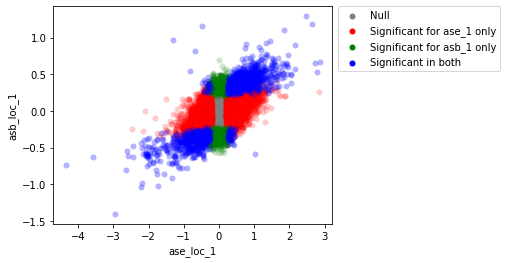

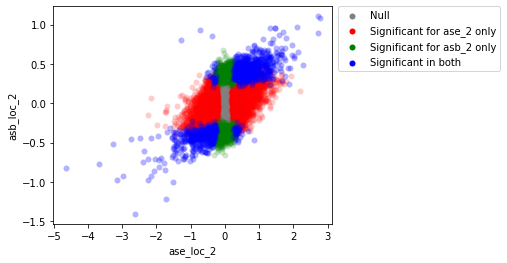

In [33]:
for rep in [1,2]: 
    correlations["gaussian"]["ase_v_asb_%i" % rep] = comparer(merged, [("ase","_%i" % rep),("asb","_%i" % rep)])  

### Laplace prior

Prop significant for ase (_1) out of ase (_2) hits: 0.398 (0.111 background rate, x3.60 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.379 (0.106 background rate, x3.60 enrichment)
Correlation of effect sizes 0.591 (p=0)
Correlation of sig effect sizes 0.713 (p=0)
Prop sig effect sizes with matching sign 0.820
Prop significant for asb (_1) out of asb (_2) hits: 0.060 (0.015 background rate, x3.94 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.061 (0.016 background rate, x3.94 enrichment)
Correlation of effect sizes 0.158 (p=0)
Correlation of sig effect sizes 0.282 (p=2.51e-116)
Prop sig effect sizes with matching sign 0.663


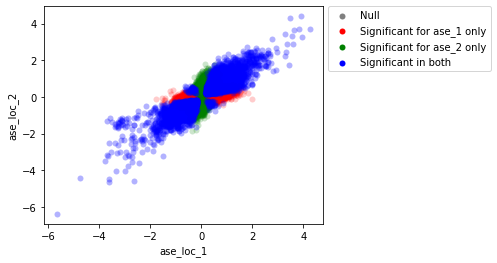

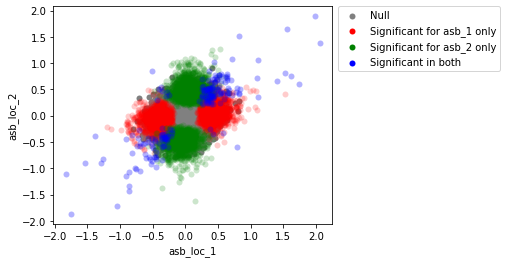

In [34]:
correlations["laplace"] = {}
res_laplace = [ pd.read_csv(results_dir / ("Laplace_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in reps ]
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]
res_laplace = [ g.loc[:,cols_to_keep] for g in res_laplace ]
merged_laplace = res_laplace[0].merge(res_laplace[1], on = ["variantID", "refAllele", "altAllele"], suffixes = ["_1","_2"])
correlations["laplace"]["ase_reps"] = comparer(merged_laplace, [("ase","_1"),("ase","_2")])  # compare ASE between replicates
correlations["laplace"]["asb_reps"] = comparer(merged_laplace, [("asb","_1"),("asb","_2")])  # compare ASB between replicates

Prop significant for ase (_1) out of asb (_1) hits: 0.178 (0.111 background rate, x1.61 enrichment)
Prop significant for asb (_1) out of ase (_1) hits: 0.025 (0.015 background rate, x1.61 enrichment)
Correlation of effect sizes 0.227 (p=0)
Correlation of sig effect sizes 0.277 (p=0)
Prop sig effect sizes with matching sign 0.645
Prop significant for ase (_2) out of asb (_2) hits: 0.170 (0.106 background rate, x1.61 enrichment)
Prop significant for asb (_2) out of ase (_2) hits: 0.025 (0.016 background rate, x1.61 enrichment)
Correlation of effect sizes 0.213 (p=0)
Correlation of sig effect sizes 0.251 (p=0)
Prop sig effect sizes with matching sign 0.636


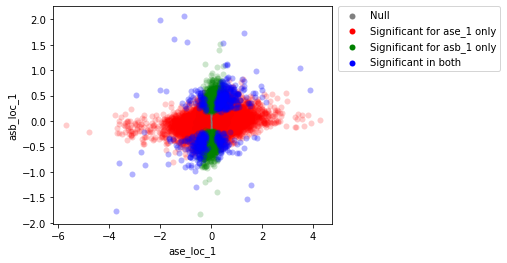

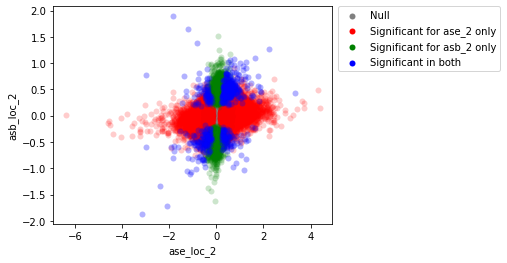

In [35]:
for rep in [1,2]:
    correlations["laplace"]["ase_v_asb_%i" % rep] = comparer(merged_laplace, [("ase","_%i" % rep),("asb","_%i" % rep)])  

### Student t

Prop significant for ase (_1) out of ase (_2) hits: 0.405 (0.102 background rate, x3.99 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.380 (0.095 background rate, x3.99 enrichment)
Correlation of effect sizes 0.612 (p=0)
Correlation of sig effect sizes 0.727 (p=0)
Prop sig effect sizes with matching sign 0.833
Prop significant for asb (_1) out of asb (_2) hits: 0.058 (0.014 background rate, x4.08 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.057 (0.014 background rate, x4.08 enrichment)
Correlation of effect sizes 0.168 (p=0)
Correlation of sig effect sizes 0.282 (p=2.44e-106)
Prop sig effect sizes with matching sign 0.674
Prop significant for ase (_1) out of asb (_1) hits: 0.153 (0.102 background rate, x1.51 enrichment)
Prop significant for asb (_1) out of ase (_1) hits: 0.021 (0.014 background rate, x1.51 enrichment)
Correlation of effect sizes 0.228 (p=0)
Correlation of sig effect sizes 0.244 (p=1.19e-322)
Prop sig effect sizes with matching si

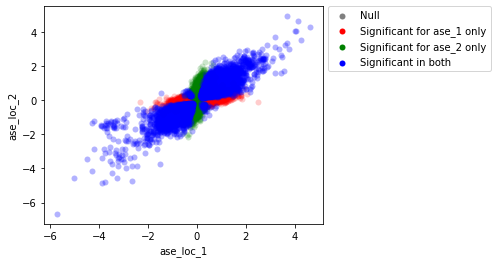

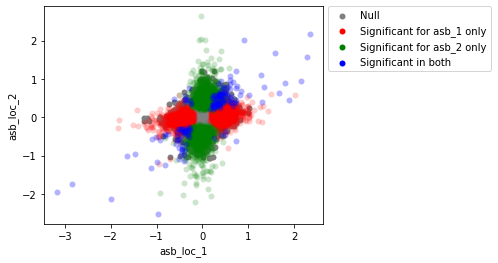

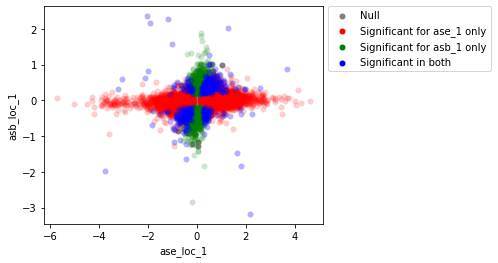

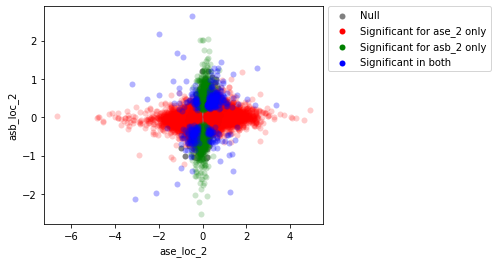

In [37]:
correlations["student_t"] = {}
res_t = [ pd.read_csv(results_dir / ("studentT_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in reps ]
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]
res_sub_t = [ g.loc[:,cols_to_keep] for g in res_t ]
merged_t = res_sub_t[0].merge(res_sub_t[1], on = ["variantID", "refAllele", "altAllele"], suffixes = ["_1","_2"])
correlations["student_t"]["ase_reps"] = comparer(merged_t, [("ase","_1"),("ase","_2")])  # 0.16, sigcor 0.30
correlations["student_t"]["asb_reps"] = comparer(merged_t, [("asb","_1"),("asb","_2")])  # 0.16, sigcor 0.30
for rep in [1,2]:
    correlations["student_t"]["ase_v_asb_%i" % rep] = comparer(merged_t, [("ase","_%i" % rep),("asb","_%i" % rep)])  

Prop significant for ase (_1) out of ase (_2) hits: 0.414 (0.107 background rate, x3.87 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.384 (0.099 background rate, x3.87 enrichment)
Correlation of effect sizes 0.609 (p=0)
Correlation of sig effect sizes 0.735 (p=0)
Prop sig effect sizes with matching sign 0.833
Prop significant for asb (_1) out of asb (_2) hits: 0.053 (0.013 background rate, x4.14 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.052 (0.013 background rate, x4.14 enrichment)
Correlation of effect sizes 0.162 (p=0)
Correlation of sig effect sizes 0.315 (p=2.94e-121)
Prop sig effect sizes with matching sign 0.671
Prop significant for ase (_1) out of asb (_1) hits: 0.235 (0.107 background rate, x2.19 enrichment)
Prop significant for asb (_1) out of ase (_1) hits: 0.028 (0.013 background rate, x2.19 enrichment)
Correlation of effect sizes 0.251 (p=0)
Correlation of sig effect sizes 0.336 (p=0)
Prop sig effect sizes with matching sign 0.691

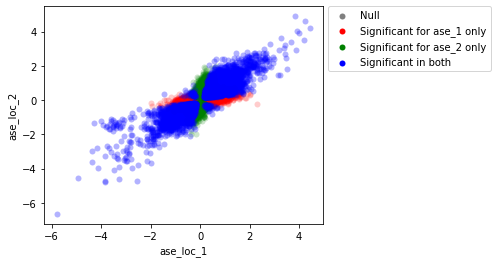

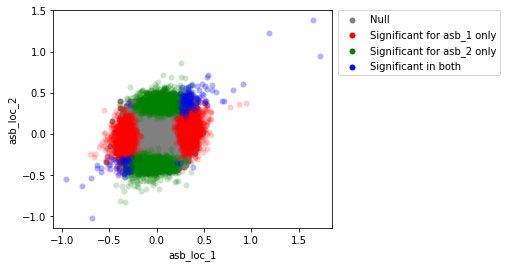

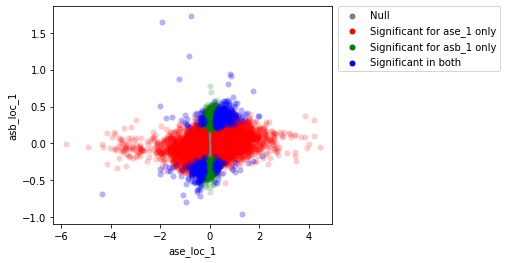

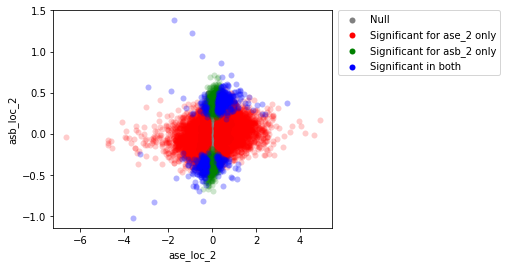

In [38]:
correlations["student_t_learnDOF"] = {}
res_t = [ pd.read_csv(results_dir / ("studentT_learnDOF_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in reps ]
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]
res_sub_t = [ g.loc[:,cols_to_keep] for g in res_t ]
merged_t = res_sub_t[0].merge(res_sub_t[1], on = ["variantID", "refAllele", "altAllele"], suffixes = ["_1","_2"])
correlations["student_t_learnDOF"]["ase_reps"] = comparer(merged_t, [("ase","_1"),("ase","_2")])  # 0.16, sigcor 0.30
correlations["student_t_learnDOF"]["asb_reps"] = comparer(merged_t, [("asb","_1"),("asb","_2")])  # 0.16, sigcor 0.30
for rep in [1,2]:
    correlations["student_t_learnDOF"]["ase_v_asb_%i" % rep] = comparer(merged_t, [("ase","_%i" % rep),("asb","_%i" % rep)])  

## Beta model replicates for hnRNPK

Results are horrible with mean field guide so only considering structured guide here. 

Prop significant for ase (_1) out of ase (_2) hits: 0.408 (0.112 background rate, x3.65 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.386 (0.106 background rate, x3.65 enrichment)
Correlation of effect sizes 0.546 (p=0)
Correlation of sig effect sizes 0.719 (p=0)
Prop sig effect sizes with matching sign 0.829


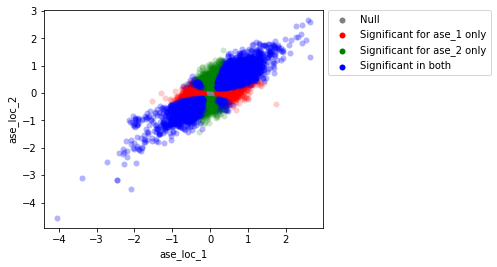

In [39]:
correlations["beta"] = {}
res_beta = [ pd.read_csv(results_dir / ("beta_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in range(2) ]
res_sub_beta = [ g.loc[:,cols_to_keep] for g in res_beta ]
merged_beta = res_sub_beta[0].merge(res_sub_beta[1], on = ["variantID", "refAllele", "altAllele"], suffixes=["_1","_2"])
correlations["beta"]["ase_reps"] = comparer(merged_beta, [("ase","_1"),("ase","_2")]) 

A lot more come out as significant using the beta model

Prop significant for asb (_1) out of asb (_2) hits: 0.145 (0.030 background rate, x4.78 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.135 (0.028 background rate, x4.78 enrichment)
Correlation of effect sizes 0.203 (p=0)
Correlation of sig effect sizes 0.422 (p=0)
Prop sig effect sizes with matching sign 0.705


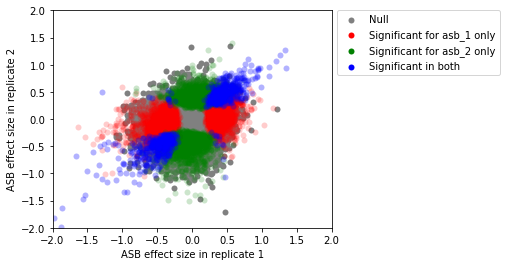

In [41]:
correlations["beta"]["asb_reps"] = comparer(merged_beta, [("asb","_1"),("asb","_2")]) 
plt.ylabel("ASB effect size in replicate 2")
plt.xlabel("ASB effect size in replicate 1")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.savefig("ASB_replicates.pdf",bbox_inches='tight')

Replicate 1 -----------
Prop significant for ase () out of asb () hits: 0.358 (0.099 background rate, x3.62 enrichment)
Prop significant for asb () out of ase () hits: 0.091 (0.025 background rate, x3.62 enrichment)
Correlation of effect sizes 0.261 (p=0)
Correlation of sig effect sizes 0.482 (p=0)
Prop sig effect sizes with matching sign 0.700
Replicate 2 -----------
Prop significant for ase () out of asb () hits: 0.325 (0.104 background rate, x3.12 enrichment)
Prop significant for asb () out of ase () hits: 0.085 (0.027 background rate, x3.12 enrichment)
Correlation of effect sizes 0.262 (p=0)
Correlation of sig effect sizes 0.458 (p=0)
Prop sig effect sizes with matching sign 0.690


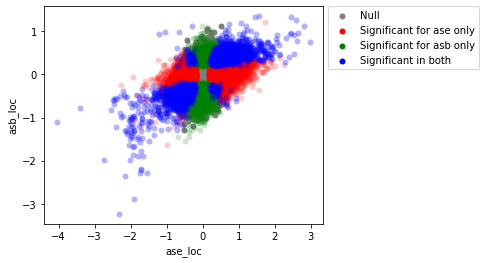

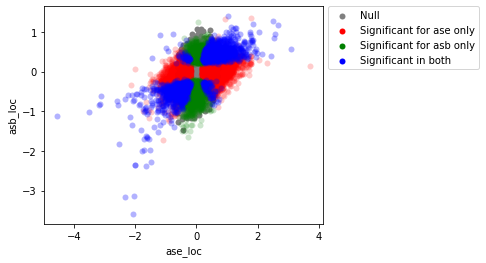

In [42]:
for i in range(2):
    print("Replicate %i -----------" % (i+1))
    correlations["beta"]["ase_v_asb_%i" % (i+1)] = comparer(res_sub_beta[i], [("ase",""),("asb","")])          

In [43]:
pd.DataFrame(correlations)

,gaussian,laplace,student_t,student_t_learnDOF,beta
ase_reps,0.536613,0.591200,0.611696,0.608699,0.546078
asb_reps,0.195557,0.158456,0.167985,0.162415,0.202534
ase_v_asb_1,0.345950,0.226511,0.228448,0.251107,0.260840
ase_v_asb_2,0.332011,0.213415,0.213978,0.243877,0.262037


## Get gene feature annotations

In [10]:
from pooledQTL import interval_utils
peaks = { k:pd.read_csv("/gpfs/commons/home/mschertzer/asb_model/all_hnrnpk_rep1_%s_peaks.narrowPeak" % k, 
                        sep = "\t",  
                        index_col = False, 
                       names = ["chrom","start","end","name","score","strand","a","b","c","d"]) for k in ["neg","pos"] }
chroms = [ "chr%i" % i for i in range(1,23) ]
its = {k:interval_utils.to_interval_trees(v, chroms) for k,v in peaks.items() }
both_strands = { chrom : its["pos"][chrom] | its["neg"][chrom] for chrom in chroms }



#overlap["in_peak"] = interval_utils.get_overlap(both_strands, overlap)

In [12]:
dbsnp151 = pd.read_csv("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/snp151Common.txt.gz", 
                       sep = "\t",  
                       index_col = False, 
                       usecols = [1,3,4,15,24], 
                       names = ["chrom","position","rsid","function","maf"])

dbsnp151.maf = dbsnp151.maf.str.split(",", expand=True, n = 2).iloc[:,:2].min(1) # only works for biallelic


In [14]:
merge2_beta = merged_beta.merge(dbsnp151.rename(columns={"rsid":"variantID"}), on = "variantID")

## Compare across models

In [146]:
comp = [ res_sub[i].merge(res_sub_beta[i], 
                          on = ["variantID", "refAllele", "altAllele"],
                         suffixes = ["_gaus","_beta"]) for i in range(2) ]
comp[0]

,variantID,refAllele,altAllele,ase_q_gaus,ase_loc_gaus,ase_sd_gaus,asb_q_gaus,asb_loc_gaus,asb_sd_gaus,ase_q_beta,ase_loc_beta,ase_sd_beta,asb_q_beta,asb_loc_beta,asb_sd_beta
0,rs1017361,A,G,0.175801,-0.170380,0.182912,0.373490,0.074849,0.232001,0.197860,-0.225637,0.265677,0.356169,0.119766,0.324816
1,rs10903832,A,G,0.387103,0.052473,0.182912,0.455968,0.022043,0.199306,0.434158,-0.029399,0.177318,0.397407,0.050919,0.195791
2,rs12357593,C,T,0.463416,-0.016797,0.182912,0.323245,-0.093211,0.203232,0.398939,-0.056694,0.221380,0.149052,-0.255452,0.245507
3,rs7908298,C,T,0.445290,-0.025163,0.182912,0.247199,0.134557,0.196913,0.498745,0.000623,0.198198,0.367004,-0.077757,0.228831
4,rs7918643,C,T,0.377667,0.056998,0.182912,0.215838,-0.162239,0.206325,0.371479,-0.053385,0.162791,0.299447,-0.140001,0.266165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350632,rs9410071,G,A,0.217672,-0.142686,0.182912,0.492020,-0.005332,0.266573,0.102073,-0.216359,0.170384,0.419750,0.050402,0.248858
350633,rs7357733,G,T,0.493592,0.002938,0.182912,0.290737,-0.147877,0.268266,0.384697,0.054250,0.185045,0.253200,-0.125225,0.188464
350634,rs766373,A,G,0.340016,-0.075436,0.182912,0.355886,0.075955,0.205573,0.367795,-0.048726,0.144288,0.258322,-0.125280,0.193175
350635,rs766375,C,T,0.477752,0.010206,0.182912,0.293708,0.110621,0.203878,0.396006,0.046951,0.178050,0.409456,0.049210,0.214942


Prop significant for asb (_gaus) out of asb (_beta) hits: 0.046 (0.002 background rate, x23.92 enrichment)
Prop significant for asb (_beta) out of asb (_gaus) hits: 0.598 (0.025 background rate, x23.92 enrichment)
Correlation of effect sizes 0.661 (p=0)
Correlation of sig effect sizes 0.809 (p=0)
Prop sig effect sizes with matching sign 0.978


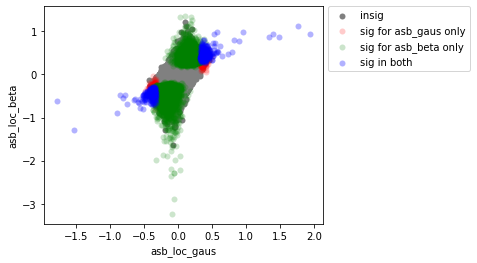

Prop significant for asb (_gaus) out of asb (_beta) hits: 0.051 (0.002 background rate, x22.94 enrichment)
Prop significant for asb (_beta) out of asb (_gaus) hits: 0.627 (0.027 background rate, x22.94 enrichment)
Correlation of effect sizes 0.682 (p=0)
Correlation of sig effect sizes 0.825 (p=0)
Prop sig effect sizes with matching sign 0.984


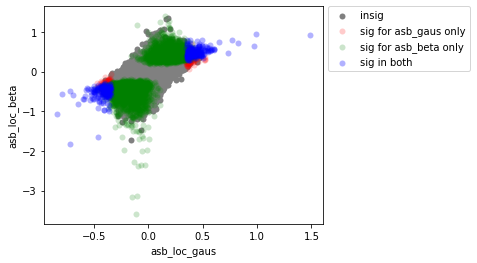

In [147]:
for i in range(2):
    comparer(comp[i], which = [("asb","_gaus"),("asb","_beta")]) # 0.71, .73

While these are pretty correlated, I'm surprised they aren't more so. 

## Compare hnRNPA1 and hnRNPK

### Gaussian model

In [148]:
HNRNPA1_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPA1")
hnrnpa1_res = pd.read_csv(HNRNPA1_dir / "normal_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
hnrnpa1_res

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.468394,-0.014125,0.178108,0.492832,0.003708,0.206388
1,rs10903832,A,G,0.489396,-0.004735,0.178108,0.430062,0.037336,0.211873
2,rs17158753,G,A,0.386755,0.051257,0.178108,0.123363,0.229247,0.197910
3,rs3740304,A,G,0.278711,-0.104492,0.178108,0.186201,0.199967,0.224183
4,rs3125027,T,C,0.272020,0.108061,0.178108,0.443887,0.028675,0.203196
...,...,...,...,...,...,...,...,...,...
261541,rs112278050,C,T,0.389345,0.050053,0.178108,0.410571,0.044846,0.198366
261542,rs9410071,G,A,0.189302,-0.156819,0.178108,0.366194,-0.068584,0.200569
261543,rs766373,A,G,0.462570,-0.016735,0.178108,0.363893,-0.070030,0.201196
261544,rs766375,C,T,0.471521,0.012725,0.178108,0.486300,-0.007706,0.224339


In [149]:
comp = res_sub[0].merge(hnrnpa1_res, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_hnrnpa1"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_hnrnpa1,ase_loc_hnrnpa1,ase_sd_hnrnpa1,asb_q_hnrnpa1,asb_loc_hnrnpa1,asb_sd_hnrnpa1
0,rs1017361,A,G,0.175801,-0.170380,0.182912,0.373490,0.074849,0.232001,0.468394,-0.014125,0.178108,0.492832,0.003708,0.206388
1,rs10903832,A,G,0.387103,0.052473,0.182912,0.455968,0.022043,0.199306,0.489396,-0.004735,0.178108,0.430062,0.037336,0.211873
2,rs4881274,G,A,0.374908,-0.058327,0.182912,0.320340,0.098729,0.211525,0.360234,-0.063733,0.178108,0.485707,0.008603,0.240067
3,rs72478223,C,T,0.452143,-0.021995,0.182912,0.389341,-0.059934,0.213262,0.422412,0.034860,0.178108,0.254957,0.131759,0.199946
4,rs7074740,C,T,0.463195,0.016899,0.182912,0.439604,-0.030145,0.198359,0.477803,0.009915,0.178108,0.448765,0.027943,0.216979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208273,rs1531164,G,A,0.358472,0.066314,0.182912,0.495735,-0.002110,0.197299,0.301708,0.092526,0.178108,0.370546,0.069077,0.209068
208274,rs112278050,C,T,0.416118,0.038747,0.182912,0.374721,0.062911,0.196980,0.389345,0.050053,0.178108,0.410571,0.044846,0.198366
208275,rs9410071,G,A,0.217672,-0.142686,0.182912,0.492020,-0.005332,0.266573,0.189302,-0.156819,0.178108,0.366194,-0.068584,0.200569
208276,rs766373,A,G,0.340016,-0.075436,0.182912,0.355886,0.075955,0.205573,0.462570,-0.016735,0.178108,0.363893,-0.070030,0.201196


Prop significant for asb (_hnrnpk) out of asb (_hnrnpa1) hits: 0.033 (0.002 background rate, x19.96 enrichment)
Prop significant for asb (_hnrnpa1) out of asb (_hnrnpk) hits: 0.029 (0.001 background rate, x19.96 enrichment)
Correlation of effect sizes 0.209 (p=0)
Correlation of sig effect sizes 0.391 (p=9.45e-25)
Prop sig effect sizes with matching sign 0.785


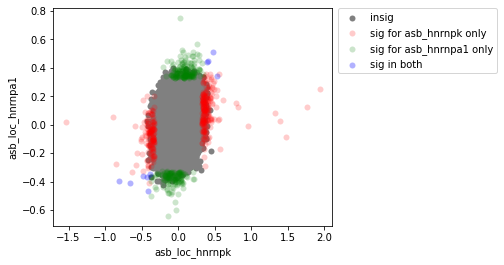

In [150]:
comparer(comp, [("asb","_hnrnpk"),("asb","_hnrnpa1")])


### Beta model

In [151]:
HNRNPA1_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPA1")
hnrnpa1_res = pd.read_csv(HNRNPA1_dir / "beta_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
hnrnpa1_res

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.081209,-0.295365,0.211430,0.142494,0.363381,0.339869
1,rs10903832,A,G,0.371776,0.063327,0.193570,0.431481,0.058757,0.340416
2,rs17158753,G,A,0.409420,0.051884,0.226532,0.051901,0.392419,0.241237
3,rs3740304,A,G,0.109203,-0.167028,0.135709,0.105418,0.249830,0.199662
4,rs3125027,T,C,0.075299,0.298241,0.207483,0.338859,-0.138918,0.334276
...,...,...,...,...,...,...,...,...,...
261541,rs112278050,C,T,0.169757,0.366768,0.383999,0.315858,-0.250881,0.523417
261542,rs9410071,G,A,0.071566,-0.243013,0.165966,0.414757,0.044989,0.208937
261543,rs766373,A,G,0.369659,-0.076912,0.231134,0.296278,-0.102810,0.192120
261544,rs766375,C,T,0.485023,0.006823,0.181701,0.237483,-0.148679,0.208110


In [152]:
comp = res_sub_beta[0].merge(hnrnpa1_res, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_hnrnpa1"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_hnrnpa1,ase_loc_hnrnpa1,ase_sd_hnrnpa1,asb_q_hnrnpa1,asb_loc_hnrnpa1,asb_sd_hnrnpa1
0,rs1017361,A,G,0.197860,-0.225637,0.265677,0.356169,0.119766,0.324816,0.081209,-0.295365,0.211430,0.142494,0.363381,0.339869
1,rs10903832,A,G,0.434158,-0.029399,0.177318,0.397407,0.050919,0.195791,0.371776,0.063327,0.193570,0.431481,0.058757,0.340416
2,rs4881274,G,A,0.350631,-0.059611,0.155392,0.399918,-0.045964,0.181276,0.217284,-0.109055,0.139564,0.400064,0.053469,0.211188
3,rs72478223,C,T,0.303201,-0.125201,0.243005,0.264904,-0.199624,0.317722,0.384442,0.069984,0.238176,0.144164,0.255999,0.241100
4,rs7074740,C,T,0.281477,0.222727,0.385034,0.239264,-0.311975,0.440226,0.258793,0.212135,0.327839,0.312332,-0.198438,0.405595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208273,rs1531164,G,A,0.358332,-0.070008,0.192902,0.374717,0.070938,0.222107,0.499575,0.000214,0.200788,0.483452,0.011717,0.282386
208274,rs112278050,C,T,0.125418,0.504671,0.439485,0.454979,-0.043067,0.380814,0.169757,0.366768,0.383999,0.315858,-0.250881,0.523417
208275,rs9410071,G,A,0.102073,-0.216359,0.170384,0.419750,0.050402,0.248858,0.071566,-0.243013,0.165966,0.414757,0.044989,0.208937
208276,rs766373,A,G,0.367795,-0.048726,0.144288,0.258322,-0.125280,0.193175,0.369659,-0.076912,0.231134,0.296278,-0.102810,0.192120


Prop significant for asb (_hnrnpk) out of asb (_hnrnpa1) hits: 0.133 (0.028 background rate, x4.81 enrichment)
Prop significant for asb (_hnrnpa1) out of asb (_hnrnpk) hits: 0.108 (0.022 background rate, x4.81 enrichment)
Correlation of effect sizes 0.264 (p=0)
Correlation of sig effect sizes 0.499 (p=0)
Prop sig effect sizes with matching sign 0.748


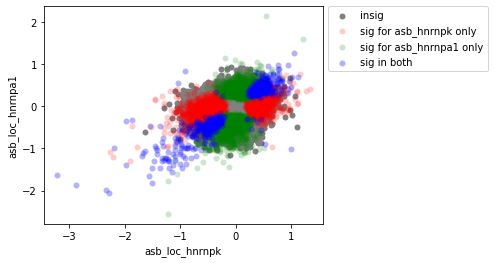

In [153]:
comparer(comp, [("asb","_hnrnpk"),("asb","_hnrnpa1")])


Stronger than the between replicate correlation :( 
So are allelic specific expression effects driving this? 

## Compare RBFOX2 vs hnRNPK

### Gaussian model

In [154]:
RBFOX2_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/RBFOX2")
rbfox2_res = pd.read_csv(RBFOX2_dir / "normal_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
rbfox2_res

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.452102,-0.022748,0.189009,0.369965,0.077245,0.232704
1,rs10903832,A,G,0.289017,-0.105138,0.189009,0.487074,0.008073,0.249127
2,rs17158753,G,A,0.276690,0.112027,0.189009,0.409577,0.054437,0.238099
3,rs3740304,A,G,0.443586,-0.026818,0.189009,0.404962,-0.056986,0.236924
4,rs2288681,T,C,0.350554,0.072547,0.189009,0.490664,-0.005274,0.225325
...,...,...,...,...,...,...,...,...,...
211953,rs766375,C,T,0.275842,-0.112506,0.189009,0.187436,-0.201680,0.227275
211954,rs72770908,G,A,0.148968,0.196735,0.189009,0.426625,0.044503,0.240589
211955,rs2229948,C,T,0.366169,0.064645,0.189009,0.279332,0.144975,0.247893
211956,rs10867108,C,T,0.391937,-0.051841,0.189009,0.485768,-0.008317,0.233091


In [155]:
comp = res_sub[0].merge(rbfox2_res, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_rbfox2"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_rbfox2,ase_loc_rbfox2,ase_sd_rbfox2,asb_q_rbfox2,asb_loc_rbfox2,asb_sd_rbfox2
0,rs1017361,A,G,0.175801,-0.170380,0.182912,0.373490,0.074849,0.232001,0.452102,-0.022748,0.189009,0.369965,0.077245,0.232704
1,rs10903832,A,G,0.387103,0.052473,0.182912,0.455968,0.022043,0.199306,0.289017,-0.105138,0.189009,0.487074,0.008073,0.249127
2,rs56400883,C,G,0.454672,0.020827,0.182912,0.495183,-0.002375,0.196669,0.497530,-0.001170,0.189009,0.288377,0.168257,0.301464
3,rs3922851,G,A,0.175234,0.170782,0.182912,0.424916,-0.053586,0.283025,0.222053,-0.144645,0.189009,0.311328,-0.111854,0.227305
4,rs3922852,G,C,0.292495,-0.099890,0.182912,0.317117,0.111793,0.234970,0.259117,0.122113,0.189009,0.458966,-0.023747,0.230466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159257,rs62579478,G,A,0.389378,0.051387,0.182912,0.481439,0.013167,0.282894,0.489781,-0.004842,0.189009,0.464141,-0.022825,0.253594
159258,rs10867107,T,C,0.491892,0.003718,0.182912,0.376228,0.062247,0.197356,0.165978,0.183374,0.189009,0.192735,0.197981,0.228126
159259,rs766373,A,G,0.340016,-0.075436,0.182912,0.355886,0.075955,0.205573,0.385797,0.054868,0.189009,0.224411,-0.186732,0.246550
159260,rs766375,C,T,0.477752,0.010206,0.182912,0.293708,0.110621,0.203878,0.275842,-0.112506,0.189009,0.187436,-0.201680,0.227275


Prop significant for asb (_hnrnpk) out of asb (_rbfox2) hits: 0.004 (0.002 background rate, x1.96 enrichment)
Prop significant for asb (_rbfox2) out of asb (_hnrnpk) hits: 0.007 (0.003 background rate, x1.96 enrichment)
Correlation of effect sizes 0.109 (p=0)
Correlation of sig effect sizes 0.143 (p=3.22e-05)
Prop sig effect sizes with matching sign 0.625


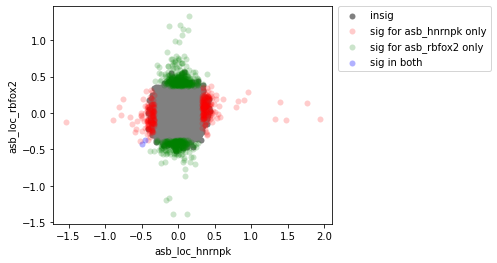

In [156]:
comparer(comp, [("asb","_hnrnpk"),("asb","_rbfox2")])

In [164]:
np.isinf(np.inf)

True

### Beta model

In [157]:
rbfox2_beta = pd.read_csv(RBFOX2_dir / "beta_struct_rep0.tsv.gz", sep = "\t", index_col = False).loc[:,cols_to_keep]
rbfox2_beta

,variantID,refAllele,altAllele,ase_q,ase_loc,ase_sd,asb_q,asb_loc,asb_sd
0,rs1017361,A,G,0.330699,-0.126263,0.288283,0.265830,0.196117,0.313550
1,rs10903832,A,G,0.357497,-0.069993,0.191679,0.390770,-0.082658,0.298069
2,rs17158753,G,A,0.265428,0.223440,0.356534,0.393115,0.126472,0.466326
3,rs3740304,A,G,0.155805,-0.149209,0.147462,0.477073,-0.015259,0.265364
4,rs2288681,T,C,0.368312,0.079262,0.235670,0.441763,-0.041551,0.283622
...,...,...,...,...,...,...,...,...,...
211953,rs766375,C,T,0.179159,-0.187636,0.204268,0.121207,-0.322032,0.275483
211954,rs72770908,G,A,0.189384,0.142163,0.161518,0.057602,0.301322,0.191287
211955,rs2229948,C,T,0.372665,-0.063366,0.195091,0.252750,0.158348,0.237809
211956,rs10867108,C,T,0.365727,-0.063479,0.184967,0.456656,-0.022708,0.208593


In [158]:
comp = res_sub_beta[0].merge(rbfox2_beta, 
                        on = ["variantID", "refAllele", "altAllele"], 
                        suffixes = ["_hnrnpk", "_rbfox2"])
comp

,variantID,refAllele,altAllele,ase_q_hnrnpk,ase_loc_hnrnpk,ase_sd_hnrnpk,asb_q_hnrnpk,asb_loc_hnrnpk,asb_sd_hnrnpk,ase_q_rbfox2,ase_loc_rbfox2,ase_sd_rbfox2,asb_q_rbfox2,asb_loc_rbfox2,asb_sd_rbfox2
0,rs1017361,A,G,0.197860,-0.225637,0.265677,0.356169,0.119766,0.324816,0.330699,-0.126263,0.288283,0.265830,0.196117,0.313550
1,rs10903832,A,G,0.434158,-0.029399,0.177318,0.397407,0.050919,0.195791,0.357497,-0.069993,0.191679,0.390770,-0.082658,0.298069
2,rs56400883,C,G,0.337994,0.065037,0.155611,0.329429,0.080115,0.181465,0.442032,0.024680,0.169250,0.204275,0.178581,0.216082
3,rs3922851,G,A,0.120245,0.198310,0.168953,0.228672,-0.146637,0.197298,0.482149,0.009594,0.214328,0.157133,-0.232093,0.230638
4,rs3922852,G,C,0.212607,-0.145694,0.182710,0.171530,0.190442,0.200859,0.485219,0.006032,0.162783,0.460145,0.017662,0.176498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159257,rs62579478,G,A,0.418219,-0.033269,0.161145,0.447400,0.022438,0.169682,0.383549,-0.067787,0.228877,0.400188,-0.062112,0.245635
159258,rs10867107,T,C,0.367017,-0.073381,0.215975,0.496182,-0.002792,0.291756,0.216843,0.152968,0.195386,0.249485,0.146575,0.216791
159259,rs766373,A,G,0.367795,-0.048726,0.144288,0.258322,-0.125280,0.193175,0.495801,-0.001861,0.176774,0.276333,-0.110201,0.185595
159260,rs766375,C,T,0.396006,0.046951,0.178050,0.409456,0.049210,0.214942,0.179159,-0.187636,0.204268,0.121207,-0.322032,0.275483


Prop significant for asb (_hnrnpk) out of asb (_rbfox2) hits: 0.084 (0.031 background rate, x2.74 enrichment)
Prop significant for asb (_rbfox2) out of asb (_hnrnpk) hits: 0.099 (0.036 background rate, x2.74 enrichment)
Correlation of effect sizes 0.131 (p=0)
Correlation of sig effect sizes 0.274 (p=5.31e-174)
Prop sig effect sizes with matching sign 0.629


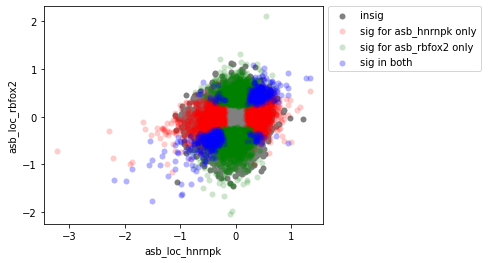

In [159]:
comparer(comp, [("asb","_hnrnpk"),("asb","_rbfox2")])

Stronger than the between replicate correlation :( 
So are allelic specific expression effects driving this? 

## BB LRT

In [22]:
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

res = pd.read_csv(results_dir / ("beta_struct_bblrt_metaan.tsv.gz"), sep = "\t", index_col = False) 

res.rename(columns = {'bb_lrt_p_1' : 'bb_lrt_q_1', 'bb_lrt_p_2' : 'bb_lrt_q_2'}, inplace = True)

In [23]:
pseudo_count = 0.25
for rep in [1,2]: 
    for source in ["input","IP"]:
        res["ratio_%s_%i" % (source,rep)] = (res["altCount_%s_%i" % (source,rep)] + pseudo_count) / ( res["refCount_%s_%i" % (source,rep)] + pseudo_count)

In [24]:
for rep in [1,2]:
    res["bb_lrt_loc_%i" % rep] = np.log(res["ratio_IP_%i" % rep] / res["ratio_input_%i" % rep])

<AxesSubplot:>

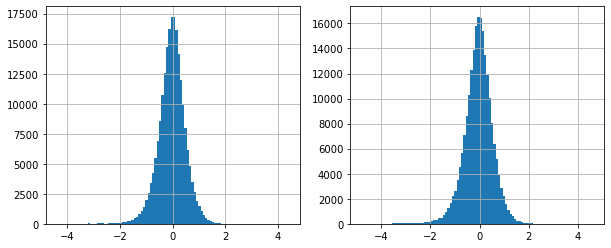

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
res["bb_lrt_loc_1"].hist(bins=100)
plt.subplot(122)
res["bb_lrt_loc_2"].hist(bins=100)

Prop significant for bb_lrt (_1) out of bb_lrt (_2) hits: 0.022 (0.007 background rate, x3.28 enrichment)
Prop significant for bb_lrt (_2) out of bb_lrt (_1) hits: 0.032 (0.010 background rate, x3.28 enrichment)
Correlation of effect sizes 0.094 (p=0)
Correlation of sig effect sizes 0.143 (p=3.36e-17)
Prop sig effect sizes with matching sign 0.597


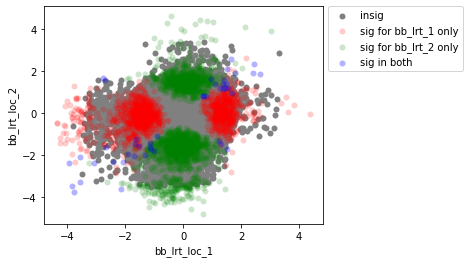

In [26]:
correlations["empirical"] = {}
correlations["empirical"]["asb_reps"] = comparer(res, [("bb_lrt","_1"),("bb_lrt","_2")], threshold=0.005)

## BB cdf for ASE

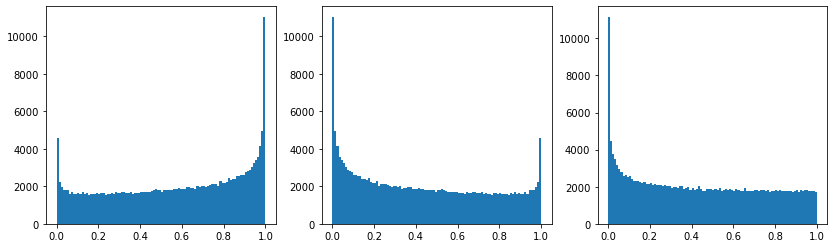

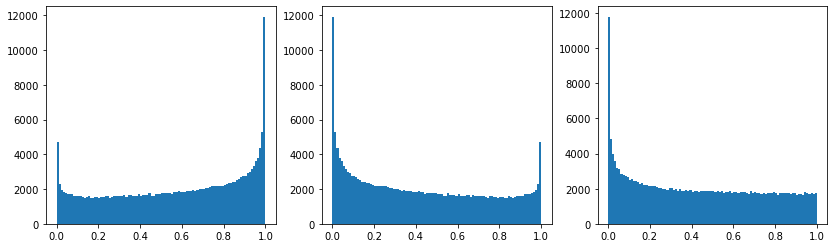

In [27]:
conc = 200. 

for rep in [1,2]:
    pred_ratio = res["pred_ratio_%i" % rep]
    p_alt_low = scipy.stats.betabinom.cdf(res["altCount_input_%i"% rep], res["totalCount_input_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    p_alt_high = scipy.stats.betabinom.sf(res["altCount_input_%i"% rep], res["totalCount_input_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    
    pv = np.minimum(p_alt_low,p_alt_high) * 2
    
    res["bb_ase_loc_%i" % rep] = np.log(res["ratio_input_%i" % rep]) - logit(res["pred_ratio_%i" % rep])
    
    _,res["bb_ase_q_%i" % rep] = statsmodels.stats.multitest.fdrcorrection(pv)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1) 
    _ = plt.hist(p_alt_low, 100)
    plt.subplot(1,3,2)
    _ = plt.hist(p_alt_high, 100)
    plt.subplot(1,3,3)
    _ = plt.hist(pv, 100)


In [28]:
np.mean(res["bb_ase_q_%i" % 1] < 0.1), np.mean(res["bb_ase_q_%i" % 2] < 0.1)

(0.03266915340667643, 0.03554936493696586)

A lot of SNP have higher than expected alt count, which seems like the opposite of reference mapping bias (!) 

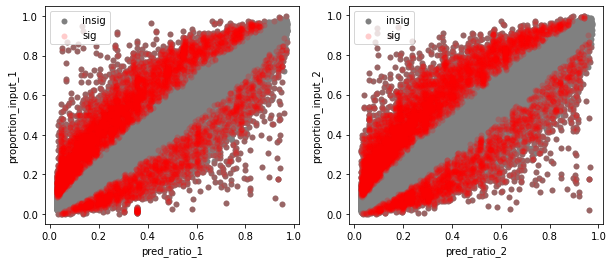

In [30]:
pseudo_count = 0.25
source = "input"
plt.figure(figsize=(10,4))
for rep in [1,2]: 
    plt.subplot(1,2,rep)
    res["proportion_%s_%i" % (source,rep)] = (res["altCount_%s_%i" % (source,rep)]) / ( res["totalCount_%s_%i" % (source,rep)])
    x_col = "pred_ratio_%i" %rep
    y_col = "proportion_input_%i" %rep
    sns.scatterplot(data = res, 
                    x=x_col, 
                    y=y_col, 
                    label = "insig",
                    color="gray", alpha = 1, linewidth=0)
    sns.scatterplot(data = res[ res["bb_ase_q_%i" % rep] < 0.1], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig",
                    color="red", alpha = 0.2, linewidth=0)

In [88]:
ct = pd.crosstab(res["bb_ase_q_1"] < 0.1, res["bb_ase_q_2"] < 0.1)
ct

bb_ase_q_2,False,True
bb_ase_q_1,,
False,199905,4966
True,4356,2563


In [89]:
scipy.stats.chi2_contingency(ct)

(23385.52471196892,
 0.0,
 1,
 array([[197587.966056,   7283.033944],
        [  6673.033944,    245.966056]]))

Prop significant for bb_ase (_1) out of bb_ase (_2) hits: 0.379 (0.022 background rate, x17.12 enrichment)
Prop significant for bb_ase (_2) out of bb_ase (_1) hits: 0.392 (0.023 background rate, x17.12 enrichment)
Correlation of effect sizes 0.379 (p=0)
Correlation of sig effect sizes 0.733 (p=0)
Prop sig effect sizes with matching sign 0.912


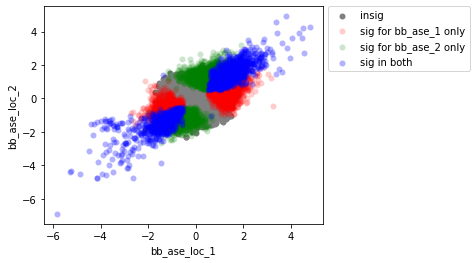

In [32]:
for rep in [1,2]: 
    res["bb_ase_loc_%i" % rep] = logit(res["proportion_input_%i" % rep]) - logit(res["pred_ratio_%i" % rep])
correlations["empirical"]["ase_reps"] = comparer(res, [("bb_ase","_1"),("bb_ase","_2")])

Prop significant for bb_ase (_1) out of bb_lrt (_1) hits: 0.079 (0.022 background rate, x3.54 enrichment)
Prop significant for bb_lrt (_1) out of bb_ase (_1) hits: 0.198 (0.056 background rate, x3.54 enrichment)
Correlation of effect sizes -0.583 (p=0)
Correlation of sig effect sizes -0.602 (p=0)
Prop sig effect sizes with matching sign 0.110


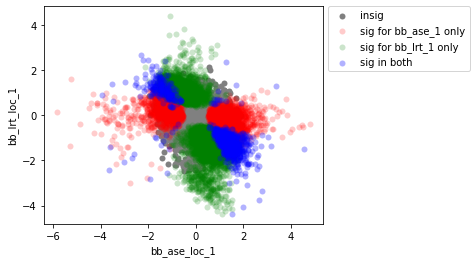

Prop significant for bb_ase (_2) out of bb_lrt (_2) hits: 0.073 (0.023 background rate, x3.17 enrichment)
Prop significant for bb_lrt (_2) out of bb_ase (_2) hits: 0.216 (0.068 background rate, x3.17 enrichment)
Correlation of effect sizes -0.543 (p=0)
Correlation of sig effect sizes -0.581 (p=0)
Prop sig effect sizes with matching sign 0.117


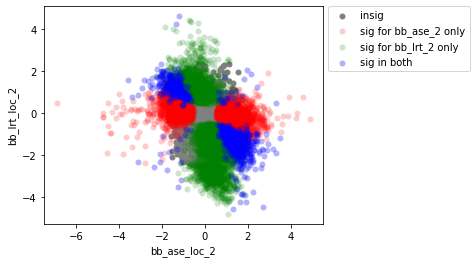

In [33]:
for rep in [1,2]: 
    correlations["empirical"]["ase_v_asb_%i" % rep] = comparer(res, [("bb_ase","_%i" % rep),("bb_lrt","_%i" % rep)])

In [34]:
pd.DataFrame(correlations)

,gaussian,laplace,student_t,beta,empirical
ase_reps,0.460548,0.601620,0.626066,0.546078,0.378965
asb_reps,0.268043,0.194470,0.186582,0.202534,0.094421
ase_v_asb_1,0.504580,0.325752,0.311095,0.260840,-0.583328
ase_v_asb_2,0.487488,0.316358,0.302999,0.262037,-0.542776


So comparing the raw data, the ASE and ASB effect sizes are negatively correlated. This makes sense because the noise in input ratio has opposite effect on each (ASE = log input ratio - log pred ratio, ASB = log IP ratio - log input ratio). Recall that in contrast, under the beta and Gaussian hierarchical Bayesian models, the effect estimates for both were postively correlated. I think the _true_ effects should be uncorrelated. But it seems the shrinkage (via modeling noise plus regularization) of the Bayesian models _overshoots_. This suggests either 1) its regularization is too aggressive and/or 2) its views the noise level as higher than it really is. The Bayesian models regularize the ASE and ASB effects directly. Given the Gaussian priors/L2-regularization it will be easiest to explain deviation from log pred ratio by putting some effect on ASE and some on ASB. Can I use a Laplace prior? Then no benefit for sharing effect. Tried this: it does improve things but not a complete fix. 

## BB cdf for ASB ignoring ASE

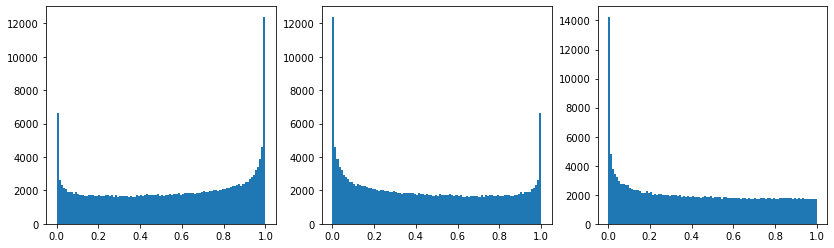

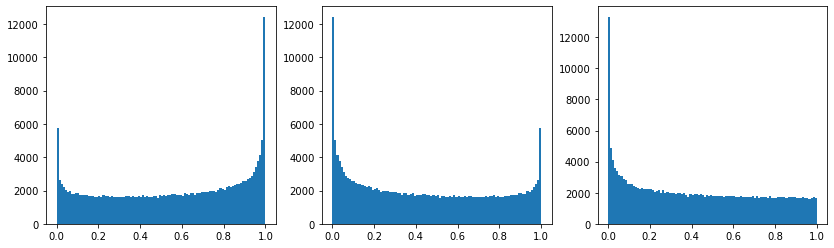

In [117]:
conc = 300. 

for rep in [1,2]:
    pred_ratio = res["pred_ratio_%i" % rep]
    p_alt_low = scipy.stats.betabinom.cdf(res["altCount_IP_%i"% rep], res["totalCount_IP_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    p_alt_high = scipy.stats.betabinom.sf(res["altCount_IP_%i"% rep], res["totalCount_IP_%i"% rep], pred_ratio * conc, (1.-pred_ratio) * conc)
    
    pv = np.minimum(p_alt_low,p_alt_high) * 2
    
    _,res["bb_asb_q_%i" % rep] = statsmodels.stats.multitest.fdrcorrection(pv)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1) 
    _ = plt.hist(p_alt_low, 100)
    plt.subplot(1,3,2)
    _ = plt.hist(p_alt_high, 100)
    plt.subplot(1,3,3)
    _ = plt.hist(pv, 100)


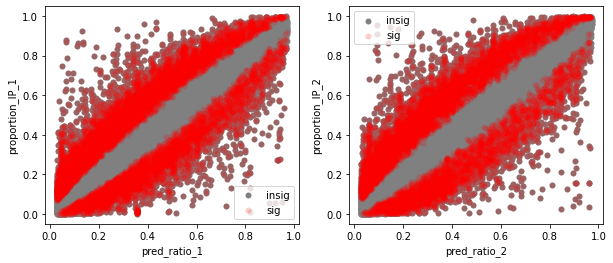

In [118]:
pseudo_count = 0.25
source = "IP"
plt.figure(figsize=(10,4))
for rep in [1,2]: 
    plt.subplot(1,2,rep)
    res["proportion_%s_%i" % (source,rep)] = (res["altCount_%s_%i" % (source,rep)] + pseudo_count) / ( res["totalCount_%s_%i" % (source,rep)] +  2*pseudo_count)
    x_col = "pred_ratio_%i" %rep
    y_col = "proportion_IP_%i" %rep
    sns.scatterplot(data = res, 
                    x=x_col, 
                    y=y_col, 
                    label = "insig",
                    color="gray", alpha = 1, linewidth=0)
    sns.scatterplot(data = res[ res["bb_asb_q_%i" % rep] < 0.1], 
                    x=x_col, 
                    y=y_col, 
                    label = "sig",
                    color="red", alpha = 0.2, linewidth=0)

In [119]:
ct = pd.crosstab(res["bb_asb_q_1"] < 0.1, res["bb_asb_q_2"] < 0.1)
ct

bb_asb_q_2,False,True
bb_asb_q_1,,
False,194952,5537
True,7079,4222


In [120]:
scipy.stats.chi2_contingency(ct)

(29125.180032195298,
 0.0,
 1,
 array([[191250.7349686,   9238.2650314],
        [ 10780.2650314,    520.7349686]]))

Prop significant for bb_asb (_1) out of bb_asb (_2) hits: 0.467 (0.038 background rate, x12.25 enrichment)
Prop significant for bb_asb (_2) out of bb_asb (_1) hits: 0.389 (0.032 background rate, x12.25 enrichment)
Correlation of effect sizes 0.386 (p=0)
Correlation of sig effect sizes 0.720 (p=0)
Prop sig effect sizes with matching sign 0.921


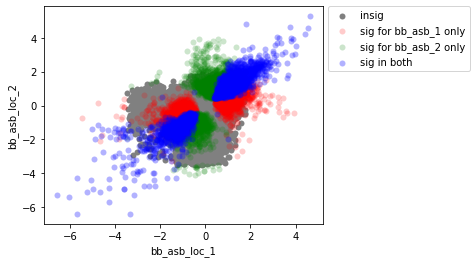

In [121]:
for rep in [1,2]: 
    res["bb_asb_loc_%i" % rep] = logit(res["proportion_IP_%i" % rep]) - logit(res["pred_ratio_%i" % rep])
comparer(res, [("bb_asb","_1"),("bb_asb","_2")])

In [127]:
[ np.mean((res["bb_asb_q_%i" % rep] < 0.1) & (res["bb_ase_q_%i" % rep] > 0.1)) for rep in [1,2] ]

[0.03652202653571934, 0.03145568723735776]

In [129]:
sig = [ (res["bb_asb_q_%i" % rep] < 0.1) & (res["bb_ase_q_%i" % rep] > 0.1) for rep in [1,2] ]

In [131]:
ct = pd.crosstab(sig[0], sig[1])
ct

col_0,False,True
row_0,,
False,198779,5276
True,6349,1386


In [132]:
scipy.stats.chi2_contingency(ct)

(5745.874319771178,
 0.0,
 1,
 array([[197636.30974078,   6418.69025922],
        [  7491.69025922,    243.30974078]]))

In [134]:
res_sub = res[ (res["bb_ase_q_%i" % 1] > 0.1) & (res["bb_ase_q_%i" % 2] > 0.1) ]

ct = pd.crosstab(res_sub["bb_asb_q_1"] < 0.1, res_sub["bb_asb_q_2"] < 0.1)
ct

bb_asb_q_2,False,True
bb_asb_q_1,,
False,188816,4435
True,5268,1386


In [135]:
scipy.stats.chi2_contingency(ct)

(7809.882952292218,
 0.0,
 1,
 array([[187623.75670443,   5627.24329557],
        [  6460.24329557,    193.75670443]]))

Prop significant for ase (_1) out of ase (_2) hits: 0.408 (0.072 background rate, x5.64 enrichment)
Prop significant for ase (_2) out of ase (_1) hits: 0.392 (0.070 background rate, x5.64 enrichment)
Correlation of effect sizes 0.602 (p=0)
Correlation of sig effect sizes 0.745 (p=0)
Prop sig effect sizes with matching sign 0.865
Prop significant for asb (_1) out of asb (_2) hits: 0.053 (0.008 background rate, x6.57 enrichment)
Prop significant for asb (_2) out of asb (_1) hits: 0.061 (0.009 background rate, x6.57 enrichment)
Correlation of effect sizes 0.194 (p=0)
Correlation of sig effect sizes 0.372 (p=9.57e-118)
Prop sig effect sizes with matching sign 0.729


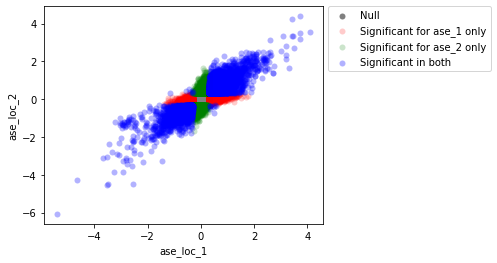

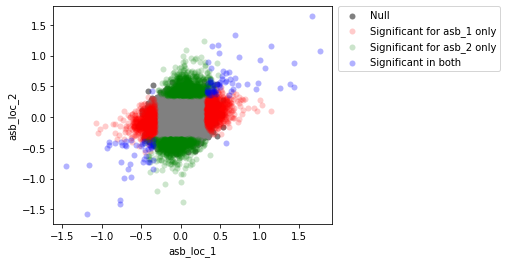

In [3]:
correlations["laplace"] = {}
res_laplace = [ pd.read_csv(results_dir / ("Laplace_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in range(2) ]
cols_to_keep = ["variantID", "refAllele", "altAllele", "ase_q", "ase_loc", "ase_sd", "asb_q", "asb_loc", "asb_sd"]
res_laplace = [ g.loc[:,cols_to_keep] for g in res_laplace ]
merged_laplace = res_laplace[0].merge(res_laplace[1], on = ["variantID", "refAllele", "altAllele"], suffixes = ["_1","_2"])
correlations["laplace"]["ase_reps"] = comparer(merged_laplace, [("ase","_1"),("ase","_2")])  # compare ASE between replicates
correlations["laplace"]["asb_reps"] = comparer(merged_laplace, [("asb","_1"),("asb","_2")]) 

Prop significant for ase () out of asb () hits: 0.420 (0.323 background rate, x1.30 enrichment)
Prop significant for asb () out of ase () hits: 0.206 (0.158 background rate, x1.30 enrichment)
Correlation of effect sizes -0.096 (p=0)
Correlation of sig effect sizes -0.105 (p=0)
Prop sig effect sizes with matching sign 0.402


-0.09568232929866213

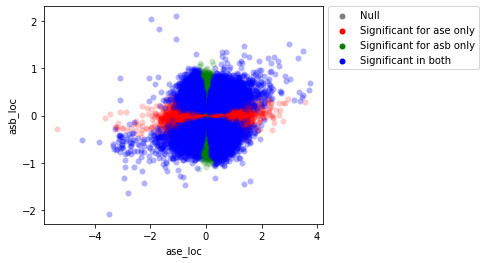

In [12]:
res_rep = pd.read_csv(results_dir / ("rep_struct_results.tsv.gz" ), sep = "\t", index_col = False) 
comparer(res_rep, [("ase",""),("asb","")]) # better than gaussian, worse than laplace/studentT/beta. 

Prop significant for ase () out of asb () hits: 0.332 (0.265 background rate, x1.25 enrichment)
Prop significant for asb () out of ase () hits: 0.157 (0.125 background rate, x1.25 enrichment)
Correlation of effect sizes -0.120 (p=0)
Correlation of sig effect sizes -0.151 (p=0)
Prop sig effect sizes with matching sign 0.415


-0.11988379831470283

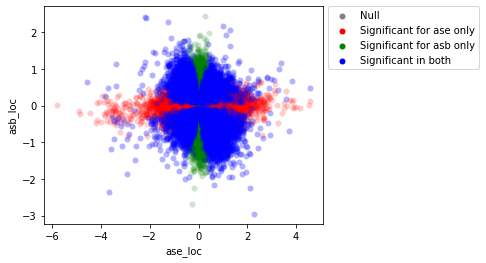

In [13]:
res_rep = pd.read_csv(results_dir / ("rep_Laplace.tsv.gz" ), sep = "\t", index_col = False) 
comparer(res_rep, [("ase",""),("asb","")]) 

Prop significant for ase () out of asb () hits: 0.332 (0.268 background rate, x1.24 enrichment)
Prop significant for asb () out of ase () hits: 0.152 (0.123 background rate, x1.24 enrichment)
Correlation of effect sizes -0.120 (p=0)
Correlation of sig effect sizes -0.151 (p=0)
Prop sig effect sizes with matching sign 0.425


-0.12017621103242382

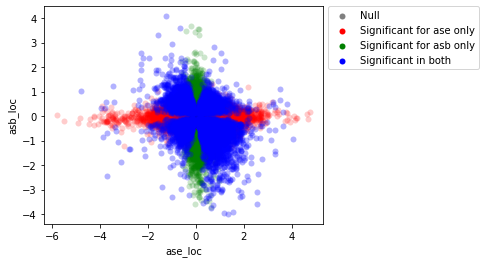

In [14]:
res_rep = pd.read_csv(results_dir / ("rep_fixed3_studentT.tsv.gz" ), sep = "\t", index_col = False) 
comparer(res_rep, [("ase",""),("asb","")]) 

Prop significant for ase () out of asb () hits: 0.354 (0.280 background rate, x1.26 enrichment)
Prop significant for asb () out of ase () hits: 0.179 (0.142 background rate, x1.26 enrichment)
Correlation of effect sizes -0.088 (p=0)
Correlation of sig effect sizes -0.112 (p=0)
Prop sig effect sizes with matching sign 0.422


-0.08844358878317665

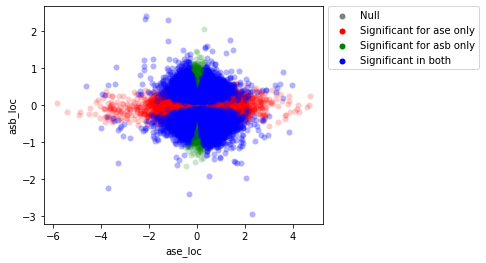

In [8]:
res_rep = pd.read_csv(results_dir / ("rep_learnt_studentT.tsv.gz" ), sep = "\t", index_col = False) 
comparer(res_rep, [("ase",""),("asb","")]) 

Prop significant for ase () out of asb () hits: 0.549 (0.075 background rate, x7.31 enrichment)
Prop significant for asb () out of ase () hits: 0.090 (0.012 background rate, x7.31 enrichment)
Correlation of effect sizes 0.438 (p=0)
Correlation of sig effect sizes 0.725 (p=0)
Prop sig effect sizes with matching sign 0.855


0.438045110266233

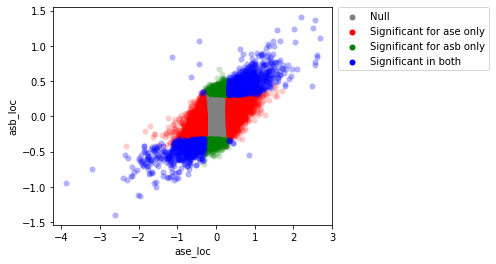

In [7]:
res_rep = pd.read_csv(results_dir / ("rep_struct_results_new.tsv.gz" ), sep = "\t", index_col = False) 
comparer(res_rep, [("ase",""),("asb","")]) 

Prop significant for ase () out of asb () hits: 0.436 (0.329 background rate, x1.32 enrichment)
Prop significant for asb () out of ase () hits: 0.162 (0.123 background rate, x1.32 enrichment)
Correlation of effect sizes 0.064 (p=9.83e-314)
Correlation of sig effect sizes 0.055 (p=1.84e-94)
Prop sig effect sizes with matching sign 0.528


0.063879704824687

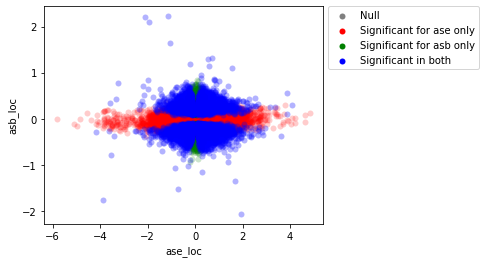

In [6]:
res_rep = pd.read_csv(results_dir / ("rep_unstruct_learnt_studentT.tsv.gz" ), sep = "\t", index_col = False) 
comparer(res_rep, [("ase",""),("asb","")]) 